In [2]:
# 读取数据
import ehr_utils, ehr_models, plot_utils
import os
import pickle
import numpy as np
import time
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
from sklearn.utils import compute_sample_weight
import pandas as pd
import time
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import compute_sample_weight
import shutil
import glob
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

In [3]:
MODEL_DIR = 'models'
LR = 1e-3
SEED = 42
N_EPOCHS = 100
BATCH_SIZE = 256
WEIGHT_DECAY = 1e-4
CKPT = 'checkpoints/stacking_best.pt'
EARLY_PATIENCE = 10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(SEED)
np.random.seed(SEED)

In [4]:
print("==> 步骤1：获取训练集和测试集 ===")
X_train, X_test, y_train, y_test = ehr_utils.preprocess_ehr_train_test_data('data_processed/benbu_baseline_cleaned_onehot.csv')
print(f"原始训练集大小：{X_train.shape}")
print(f"原始测试集大小：{X_test.shape}")
models = ehr_utils.load_all_pkls(MODEL_DIR)

==> 步骤1：获取训练集和测试集 ===
总特征数：96，需要log1p变换的特征数：66
训练集样本数：8000，验证集样本数：2000
原始训练集大小：(8000, 96)
原始测试集大小：(2000, 96)
[INFO] 共加载 10 个模型：['AdaBoost_cv_0.5042', 'DecisionTree_cv_0.4930', 'GaussianNB_cv_0.4886', 'GradientBoosting_cv_0.5097', 'LightGBM_cv_0.4985', 'LinearDiscriminantAnalysis_cv_0.4882', 'LogisticRegression_cv_0.4908', 'MLPClassifier_cv_0.5016', 'RandomForest_cv_0.4996', 'XGBoost_cv_0.4972']


In [7]:
meta_train = ehr_utils.generate_meta_features(models, X_train, cache_name='meta_train', cache_dir='cache')
meta_test  = ehr_utils.generate_meta_features(models, X_test,  cache_name='meta_test', cache_dir='cache')

[INFO] 直接读取缓存: cache\meta_train.pt
[INFO] 直接读取缓存: cache\meta_test.pt


In [ ]:
meta_train = meta_train.to(device)
print(meta_train.shape)
meta_test = meta_test.to(device)
y_train_t = torch.tensor(y_train.values, dtype=torch.float32).to(device)
y_test_t = torch.tensor(y_test.values, dtype=torch.float32).to(device)

# 构建 Dataset / DataLoader
train_ds = TensorDataset(meta_train, y_train_t)
valid_ds = TensorDataset(meta_test, y_test_t)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)


def train_or_load_model(model, train_loader, valid_loader, device, epochs=100, lr=1e-3, wd=1e-4, patience=10, reTrain=False):
    """
    返回已经训练好（或缓存）的模型
    """
    os.makedirs(os.path.dirname(CKPT), exist_ok=True)
    # 如果需要重新训练，且存在缓存权重，则直接加载
    if reTrain and os.path.exists(CKPT):
        print(f'>>> 发现缓存权重 {CKPT}，跳过训练')
        model.load_state_dict(torch.load(CKPT, map_location=device))
        return model

    criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor((y_train == 0).sum() / (y_train == 1).sum(), dtype=torch.float32, device=device))
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)

    best_auc, patience_cnt = 0., 0

    for epoch in range(1, epochs + 1):
        # --- 训练 ---
        model.train()
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            loss = criterion(model(x), y)
            loss.backward()
            optimizer.step()

        # --- 验证 ---
        model.eval()
        with torch.no_grad():
            logits = torch.cat([model(xb.to(device)) for xb, _ in valid_loader])
            probs = torch.sigmoid(logits).cpu().numpy()
            auc = roc_auc_score(y_test, probs)

        if auc > best_auc + 1e-4:
            best_auc = auc
            patience_cnt = 0
            torch.save(model.state_dict(), CKPT)
        else:
            patience_cnt += 1
            if patience_cnt >= patience:
                print('Early stop')
                break

    # 训练结束再加载最优
    model.load_state_dict(torch.load(CKPT, map_location=device))
    return model


# 主流程
model = ehr_models.StackingMLP(meta_train.shape[1]).to(device)
model = train_or_load_model(model, train_loader, valid_loader, device)

torch.Size([8000, 10])
Early stop


>> 训练集 vs 验证集 最优阈值指标（Youden）
           Train      Test      
Sensitivity 0.872      0.488     
Specificity 0.904      0.549     
C-index    0.957      0.509     
Youden     0.776      0.038     
Cut-point  0.514      0.512     


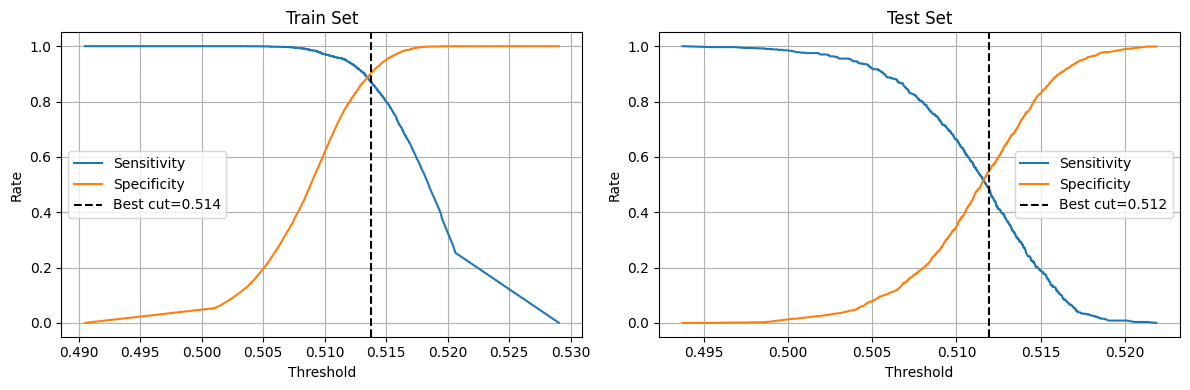

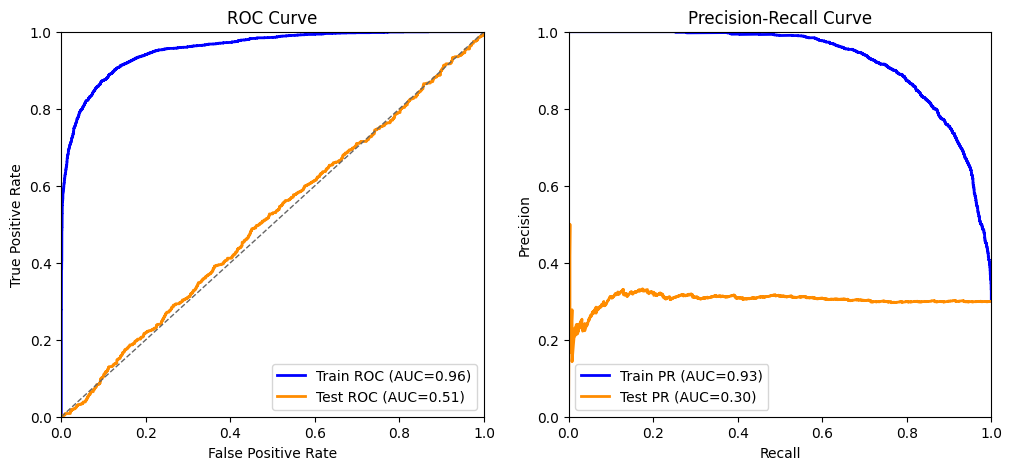

Train AUROC: 0.9570, Test AUROC: 0.5092
Train AUPRC: 0.9269, Test AUPRC: 0.3041
过拟合程度：0.4478


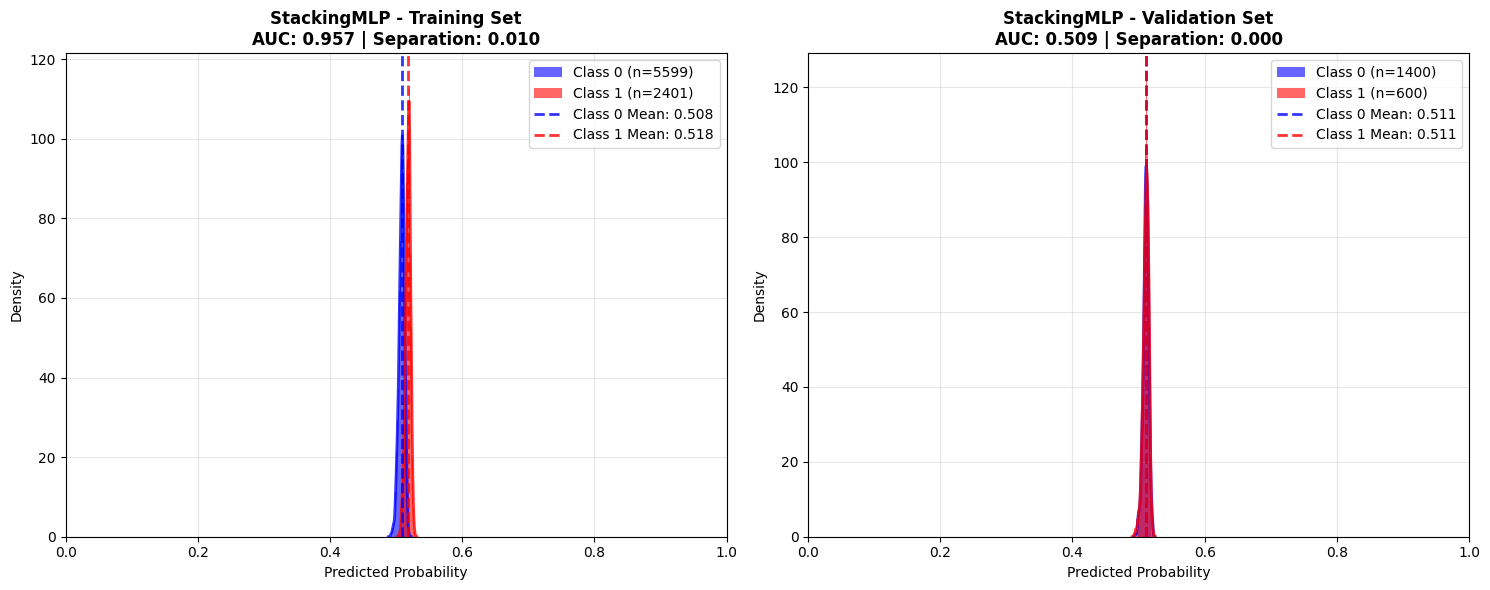

=== StackingMLP 概率分布统计 ===
训练集:
  Class 0: 均值=0.508, 标准差=0.004
  Class 1: 均值=0.518, 标准差=0.004
  分离度: 0.010, AUC: 0.957
验证集:
  Class 0: 均值=0.511, 标准差=0.004
  Class 1: 均值=0.511, 标准差=0.004
  分离度: 0.000, AUC: 0.509
过拟合指标:
  AUC差异: 0.448
  分离度差异: 0.010


In [ ]:
mlp_wrapper = ehr_models.PytorchModelWrapper(model, device)

# 3. 得到概率（用于绘图函数）
train_proba = mlp_wrapper.predict_proba(meta_train.cpu())
test_proba = mlp_wrapper.predict_proba(meta_test.cpu())

# 4. 一键三连分析
_ = ehr_utils.report_sens_spec(y_train.values, train_proba[:, 1], y_test.values, test_proba[:, 1], plot=True)

plot_utils.plot_roc_pr_curves(y_train.values, train_proba[:, 1], y_test.values, test_proba[:, 1], model_name='StackingMLP')
plot_utils.prob_distributions(mlp_wrapper, pd.DataFrame(meta_train.cpu().numpy()), y_train, pd.DataFrame(meta_test.cpu().numpy()), y_test, model_name='StackingMLP')